# Feature 

In [1]:
import requests as rq
import json
import numpy as np
import pickle
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import snownlp
from tqdm import tqdm
from time import sleep
from bs4 import BeautifulSoup
from nltk.sentiment.vader import SentimentIntensityAnalyzer 
from textblob import TextBlob
from snownlp import SnowNLP


<font size=6>Read file</font>

In [2]:
train = pd.read_pickle('C:/Users/88690/Desktop/人工/NYCU-Intro-AI-Project/final-project/nytimes-dataset/train_modified.pkl')
feat_data = 'feat_modified_v1'
train


,web_url,print_section,print_page,news_desk,section_name,type_of_material,word_count,subsection_name,pub_year,pub_month,...,abstract_len,abstract_dup,headline,headline_len,headline_dup,headline_kicker,len_lead,keywords,authors,n_comment
0,https://www.nytimes.com/2020/12/31/opinion/202...,A,18,OpEd,Opinion,Op-Ed,882,NaN,2021,1,...,8,0,Things Will Get Better. Seriously.,5,0,None,54,"[Biden, Joseph R Jr, United States Economy, La...",[Paul Krugman],854
1,https://www.nytimes.com/2021/01/01/sports/ncaa...,B,9,Sports,Sports,News,1316,College Football,2021,1,...,27,0,"In Pasadena, Moving the Rose Bowl Makes For Un...",10,0,None,48,"[Football (College), Rose Bowl (Football Game)...",[Billy Witz],61
2,https://www.nytimes.com/2021/01/01/well/family...,NaN,NaN,Well,Well,News,1044,Family,2021,1,...,33,0,Teaching My Child to Love a Dying World,8,0,Ties,85,"[Trees and Shrubs, Children and Childhood, Par...",[Shoshana Meira Friedman],65
3,https://www.nytimes.com/2021/01/01/upshot/why-...,B,5,Upshot,The Upshot,News,1462,NaN,2021,1,...,23,0,Why Markets Boomed in a Year of Human Misery,9,0,None,30,"[United States Economy, Labor and Jobs, Consum...","[Neil Irwin, Weiyi Cai]",418
4,https://www.nytimes.com/2021/01/01/climate/tru...,A,19,Climate,Climate,News,1582,NaN,2021,1,...,25,0,"How Trump Tried, but Largely Failed, to Derail...",12,0,None,49,"[Global Warming, Environment, Research, United...",[Christopher Flavelle],10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20109,https://www.nytimes.com/2022/12/31/opinion/sou...,NaN,NaN,OpEd,Opinion,Op-Ed,2021,NaN,2022,12,...,11,0,The Shameful Open Secret Behind Southwest’s Fa...,7,0,Zeynep Tufekci,47,"[Southwest Airlines Company, AIRLINES AND AIRP...",[Zeynep Tufekci],550
20110,https://www.nytimes.com/2022/12/31/opinion/202...,SR,2,OpEd,Opinion,Op-Ed,984,NaN,2022,12,...,18,0,Cheer Up! The World Is Better Off Than You Think.,10,0,Nicholas Kristof,16,"[Two Thousand Twenty Two, Coronavirus (2019-nC...",[Nicholas Kristof],311
20111,https://www.nytimes.com/2022/12/31/us/politics...,NaN,NaN,Investigative,U.S.,News,7958,Politics,2022,12,...,22,0,The Invention of Elise Stefanik,5,0,None,5,"[Stefanik, Elise, Trump, Donald J, Republican ...",[Nicholas Confessore],814
20112,https://www.nytimes.com/2022/12/31/world/asia/...,NaN,NaN,Foreign,World,News,3523,Asia Pacific,2022,12,...,33,0,Russia’s War Could Make It India’s World,7,0,None,47,"[vis-photo, International Relations, Politics ...","[Roger Cohen, Mauricio Lima]",325


<font size=6>Set bound of popularity</font>

In [3]:
median = train['n_comment'].median()
print(median)
train['is_popular'] = train['n_comment'].apply(lambda x : 1 if x > median else 0)
pop_count = 0
for i in train['is_popular']:
    if i:
        pop_count += 1
print('popular:    ' , pop_count / len(train))
print('not popular:' , 1 - pop_count / len(train))
#train = train.drop(columns = ['n_comment'])

59.0
popular:     0.4972158695436015
not popular: 0.5027841304563985


In [4]:
print(train.columns)

Index(['web_url', 'print_section', 'print_page', 'news_desk', 'section_name',
       'type_of_material', 'word_count', 'subsection_name', 'pub_year',
       'pub_month', 'pub_day', 'pub_weekday', 'pub_time', 'abstract',
       'abstract_len', 'abstract_dup', 'headline', 'headline_len',
       'headline_dup', 'headline_kicker', 'len_lead', 'keywords', 'authors',
       'n_comment', 'is_popular'],
      dtype='object')


<font size=6>Hour</font>


pub_time
0     0.724070
1     0.569288
2     0.747017
3     0.667925
4     0.263314
5     0.298969
6     0.268707
7     0.541130
8     0.494705
9     0.544521
10    0.537093
11    0.262000
12    0.381733
13    0.294192
14    0.360767
15    0.479393
16    0.479581
17    0.450980
18    0.412831
19    0.508748
20    0.468268
21    0.464516
22    0.524272
23    0.694517
Name: is_popular, dtype: float64
0.13820100863582516


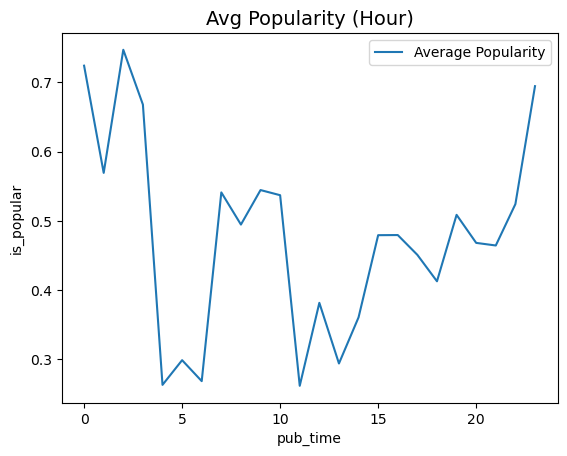

In [5]:
print(train.groupby('pub_time').mean()['is_popular'])
sns.lineplot(data = train.groupby('pub_time').mean()['is_popular'],  label='Average Popularity')
plt.title('Avg Popularity (Hour)', fontsize=14)
#plt.axvline(x = 3, linestyle= '--')

train['is_noon'] = train['pub_time'].apply(lambda x : 1 if (x <= 3 or x >= 23) else 0)
print(train.corr()['is_popular']['is_noon'])

<font size=6>Weekday</font>

In [6]:
print(train.groupby('pub_weekday').mean()['is_popular'])

pub_weekday
0    0.494849
1    0.501787
2    0.465750
3    0.464994
4    0.484355
5    0.705448
6    0.547342
Name: is_popular, dtype: float64


<font size=6>Day of week</font>

0.09934992425884584


Text(0.5, 1.0, 'Avg Popularity (Day of Week)')

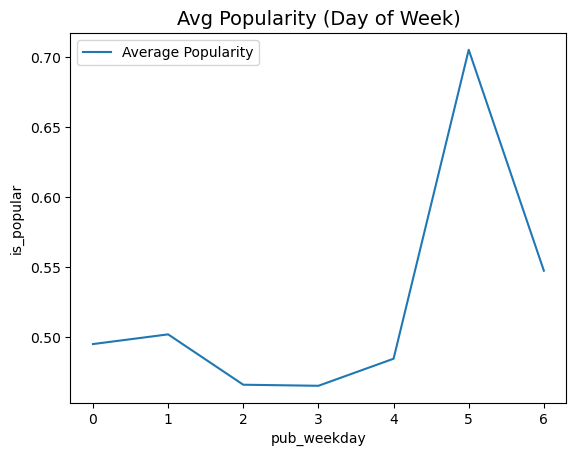

In [7]:
train['is_saturday'] = train['pub_weekday'].apply(lambda x : 1 if (x == 5) else 0)
print(train.corr()['is_popular']['is_saturday'])
sns.lineplot(data = train.groupby('pub_weekday').mean()['is_popular'],  label='Average Popularity')
plt.title('Avg Popularity (Day of Week)', fontsize=14)


<font size=6>Day of month</font>

pub_day
1     0.500722
2     0.549383
3     0.505247
4     0.483969
5     0.498361
6     0.500775
7     0.467143
8     0.489333
9     0.499270
10    0.487555
11    0.520000
12    0.516381
13    0.504298
14    0.496218
15    0.517094
16    0.490455
17    0.502256
18    0.469649
19    0.505970
20    0.493827
21    0.465616
22    0.496503
23    0.481191
24    0.503215
25    0.495908
26    0.506452
27    0.496923
28    0.486370
29    0.495385
30    0.503984
31    0.480519
Name: is_popular, dtype: float64


Text(0.5, 1.0, 'Avg Popularity (day)')

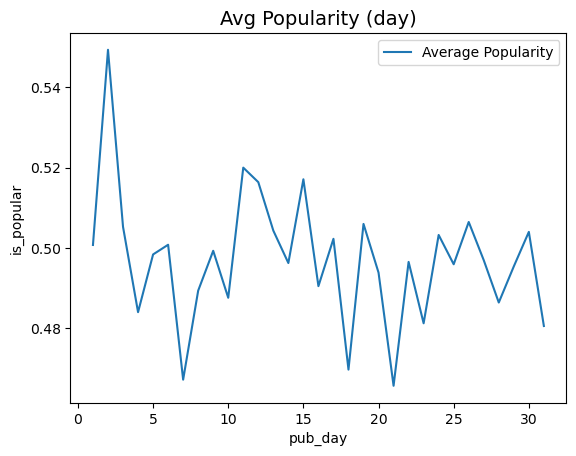

In [8]:
print(train.groupby('pub_day').mean()['is_popular'])
sns.lineplot(data = train.groupby('pub_day').mean()['is_popular'],  label='Average Popularity')
plt.title('Avg Popularity (day)', fontsize=14)

<font size=6>Month</font>

pub_month
1     0.523143
2     0.495250
3     0.477819
4     0.476914
5     0.440885
6     0.472205
7     0.499048
8     0.524611
9     0.488180
10    0.520438
11    0.521981
12    0.532374
Name: is_popular, dtype: float64
0.06693532304195769


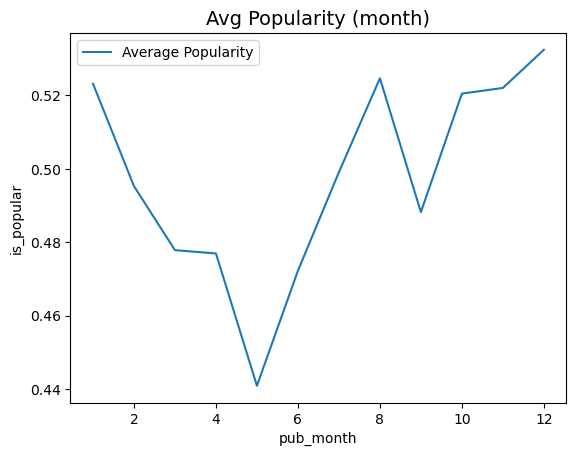

In [9]:
print(train.groupby('pub_month').mean()['is_popular'])
sns.lineplot(data = train.groupby('pub_month').mean()['is_popular'],  label='Average Popularity')
plt.title('Avg Popularity (month)', fontsize=14)
train['is_lowmonth'] = train['pub_time'].apply(lambda x : 0 if (x >= 3 and x <= 6) else 1)
print(train.corr()['is_popular']['is_lowmonth'])
#print(train.corr()['is_popular']['is_noon'])

<font size=6>News desk</font>

In [10]:
train['group_by_news_desk'] = train['is_popular'].groupby(train['news_desk']).transform('mean')
#train
#train = train.sort_values(['group_by_news_desk'],ascending=False)
print(train.corr()['is_popular']['group_by_news_desk'])
train['feature_news_desk'] = train['group_by_news_desk'].apply(lambda x : round(x, 1))
print(train.corr()['is_popular']['feature_news_desk'])

0.5386686658866031
0.5356391608755238


<font size=6>Section</font>

In [11]:
train['group_by_section_name'] = train['is_popular'].groupby(train['section_name']).transform('mean')
#train = train.sort_values(['group_by_section_name'],ascending=False)
print(train.corr()['is_popular']['group_by_section_name'])
train['feature_section_name'] = train['group_by_news_desk'].apply(lambda x : round(x, 1))
print(train.corr()['is_popular']['feature_section_name'])

0.5264210380989329
0.5356391608755238


<font size=6>Subsection</font>

In [12]:
train['group_by_subsection_name'] = train['is_popular'].groupby(train['subsection_name']).transform('mean')
##train = train.sort_values(['group_by_subsection_name'],ascending=False)
print(train.corr()['is_popular']['group_by_subsection_name'])
train['feature_subsection_name'] = train['group_by_subsection_name'].apply(lambda x : round(x, 1))
print(train.corr()['is_popular']['feature_subsection_name'])

0.5489145212913439
0.5468229804957673


<font size=6>Material</font>

In [13]:
train['group_by_type_of_material'] = train['is_popular'].groupby(train['type_of_material']).transform('mean')
train = train.sort_values(['group_by_type_of_material'],ascending=False)
print(train.corr()['is_popular']['group_by_type_of_material'])
train['feature_type_of_material'] = train['group_by_type_of_material'].apply(lambda x : round(x, 1))
print(train.corr()['is_popular']['feature_type_of_material'])

0.37409023464330043
0.37337428003708234


<font size=6>Keyword</font>

<font size=5>Politics<font size=4>( party, congress, president )</font></font>


In [14]:
train['is_party'] = train['keywords'].apply(lambda x: 1 if ('Democratic Party' in x or 'Republican Party' in x ) else 0)
train['is_congress'] = train['keywords'].apply(lambda x: 1 if ('House of Representatives' in x or 'Senate' in x) else 0)
train['is_president'] = train['keywords'].apply(lambda x: 1 if ('Trump, Donald J' in x or 'Biden, Joseph R Jr' in x)else 0)
print(train.corr()['is_popular']['is_party'])
print(train.corr()['is_popular']['is_congress'])
print(train.corr()['is_popular']['is_president'])

0.1934972004528069
0.12242209431136794
0.22532736133233658


<font size=5>Event <font size=4>( Ukrainian_Russian_war, covid, Storming of the US Capitol )</font></font>


In [15]:
train['is_ukrainian_russian_war'] = train['keywords'].apply(lambda x: 1 if ('War and Armed Conflicts' in x or 'Ukraine' in x ) else 0)
train['is_covid'] = train['keywords'].apply(lambda x: 1 if 'Coronavirus (2019-nCoV)' in x else 0)
train['is_storm'] = train['keywords'].apply(lambda x: 1 if 'Storming of the US Capitol (Jan, 2021)' in x else 0)
print('ukrainian_russian_war     ', train.corr()['is_popular']['is_ukrainian_russian_war'])
print('Coronavirus               ', train.corr()['is_popular']['is_covid'])
print('Storming of the US Capitol', train.corr()['is_popular']['is_storm'])

ukrainian_russian_war      0.047935123813753346
Coronavirus                0.04315828531089032
Storming of the US Capitol 0.11618543000667257


<font size=5>News game<font size=4>(spelling bee, crossword puzzle)</font></font>

In [16]:
train['is_spell'] = train['keywords'].apply(lambda x: 1 if 'Spelling Bee (Game)' in x else 0)
train['is_crossword'] = train['keywords'].apply(lambda x: 1 if 'Crossword Puzzles' in x else 0)
train['is_game'] = train['keywords'].apply(lambda x: 1 if 'Spelling Bee (Game)'  in x or 'Crossword Puzzles' in x else 0)
print(train.corr()['is_popular']['is_spell'])
print(train.corr()['is_popular']['is_crossword'])
print(train.corr()['is_popular']['is_game'])

0.0907525756908546
0.11684484978702632
0.14937243866766028


<font size=6>Headline length</font>

-0.021881346779628184


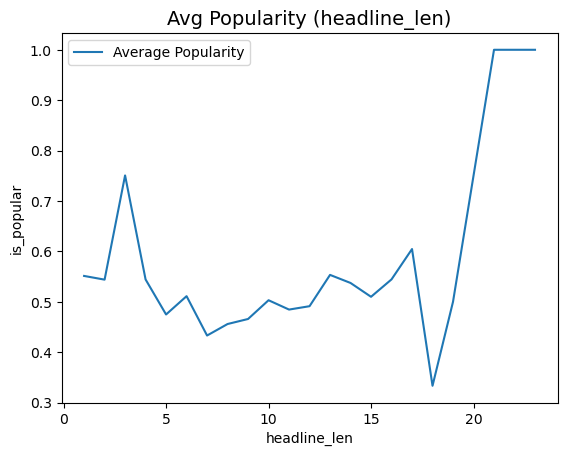

In [17]:
#print(train.groupby('abstract_len').mean()['is_popular'])
sns.lineplot(data = train.groupby('headline_len').mean()['is_popular'],  label='Average Popularity')
plt.title('Avg Popularity (headline_len)', fontsize=14)
print(train.corr()['is_popular']['headline_len'])

<font size=6>Abstract length</font>

-0.13785591469033517


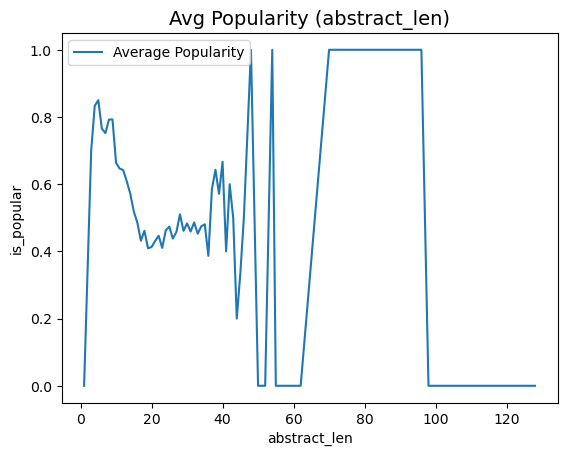

In [18]:
#print(train.groupby('abstract_len').mean()['is_popular'])
sns.lineplot(data = train.groupby('abstract_len').mean()['is_popular'],  label='Average Popularity')
plt.title('Avg Popularity (abstract_len)', fontsize=14)
print(train.corr()['is_popular']['abstract_len'])

<font size=6>Word count</font>

0.14150279357111972


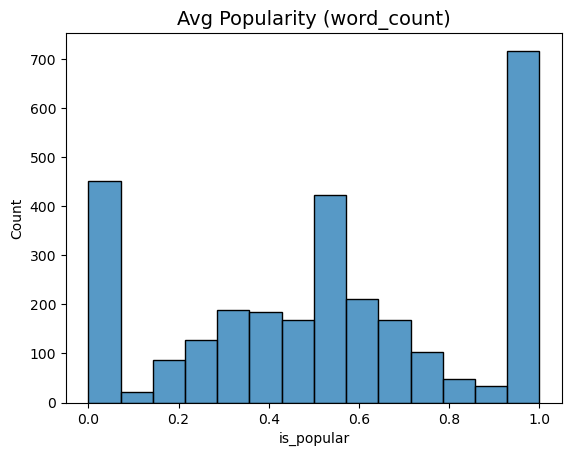

In [19]:
#print(train.groupby('abstract_len').mean()['is_popular'])
sns.histplot(data = train.groupby('word_count').mean()['is_popular'],  label='Average Popularity')
plt.title('Avg Popularity (word_count)', fontsize=14)
print(train.corr()['is_popular']['word_count'])

0.10125151149680278


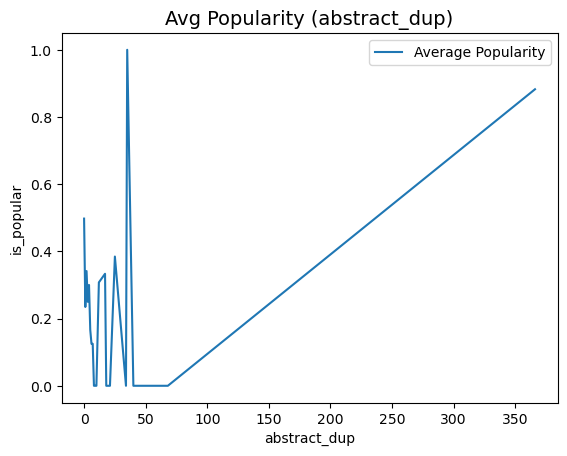

In [20]:
#print(train.groupby('abstract_len').mean()['is_popular'])
sns.lineplot(data = train.groupby('abstract_dup').mean()['is_popular'],  label='Average Popularity')
plt.title('Avg Popularity (abstract_dup)', fontsize=14)
print(train.corr()['is_popular']['abstract_dup'])

<font size=6>Lead paragraph length</font>

0.05655971245094995


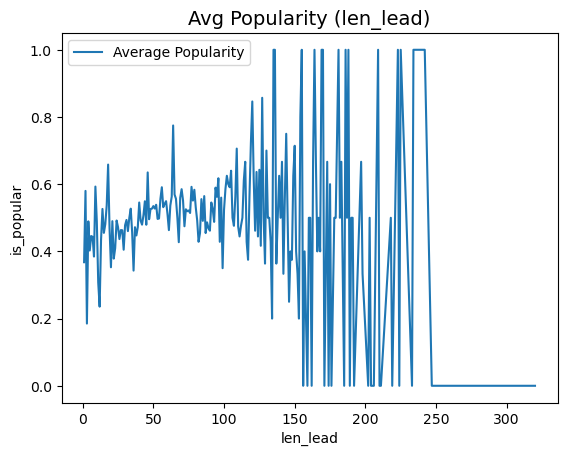

In [21]:
#print(train.groupby('abstract_len').mean()['is_popular'])
sns.lineplot(data = train.groupby('len_lead').mean()['is_popular'],  label='Average Popularity')
plt.title('Avg Popularity (len_lead)', fontsize=14)
print(train.corr()['is_popular']['len_lead'])

<font size = 6>Sentiment analyze</font>

<font size = 5>punctuation removal</font>

In [22]:
punct_list = list('!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~')
def remove_punctuation(headline):
    for punc in punct_list:
        if punc in headline:
            headline = headline.replace(punc, ' ')
    return headline
train['clean_headline'] = train['headline'].apply(lambda x: remove_punctuation(x))

<font size = 5>textblob</font>

In [23]:

text = "i am happy today."
blob = TextBlob(text)
# get the sentiment of the text
sentiment = blob.sentiment
print(sentiment)

Sentiment(polarity=0.8, subjectivity=1.0)


In [24]:
def tb_score_polar(headline):
    score = TextBlob(headline).sentiment[0]
    return score
def tb_score_subj(headline):
    score = TextBlob(headline).sentiment[1]
    return score
train['sentiment_tb_polar'] = train['clean_headline'].apply(lambda x : tb_score_polar(x))#-1 ~ 1
train['sentiment_tb_polar_abs'] = train['sentiment_tb_polar'].apply(lambda x :abs(x))#0 ~ 1
train['sentiment_tb_subj'] = train['clean_headline'].apply(lambda x : tb_score_subj(x))#0 ~ 1
train['sentiment_tb_pos'] = train['sentiment_tb_polar'].apply(lambda x : 1 if x > 0 else 0)#bool
train['sentiment_tb_neg'] = train['sentiment_tb_polar'].apply(lambda x : 1 if x <= 0 else 0)#bool
print(train.corr()['is_popular']['sentiment_tb_polar'])
print(train.corr()['is_popular']['sentiment_tb_polar_abs'])
print(train.corr()['is_popular']['sentiment_tb_subj'])
print(train.corr()['is_popular']['sentiment_tb_pos'])
print(train.corr()['is_popular']['sentiment_tb_neg'])

-0.032621091345729485
0.006646783622724825
-0.002089231022134771
-0.023527811728766668
0.02352781172876634


<font size = 5>vader</font>

In [25]:
headline = 'today is a sunny day!'
analyzer = SentimentIntensityAnalyzer ()
sentiment_dict = analyzer.polarity_scores(headline)
print(sentiment_dict)

{'neg': 0.0, 'neu': 0.492, 'pos': 0.508, 'compound': 0.4753}


In [26]:
train['sentiment_vader_neg'] = train['clean_headline'].apply(lambda x : analyzer.polarity_scores(x)['neg'])#0 ~ 1
train['sentiment_vader_neu'] = train['clean_headline'].apply(lambda x : analyzer.polarity_scores(x)['neu'])#0 ~ 1
train['sentiment_vader_pos'] = train['clean_headline'].apply(lambda x : analyzer.polarity_scores(x)['pos'])#0 ~ 1
train['sentiment_vader_compound'] = train['clean_headline'].apply(lambda x : analyzer.polarity_scores(x)['compound'])#-1 ~ 1
train['sentiment_vader_compound_abs'] = train['sentiment_vader_compound'].apply(lambda x : abs(x))#0 ~ 1
print(train.corr()['is_popular']['sentiment_vader_neg'])
print(train.corr()['is_popular']['sentiment_vader_neu'])
print(train.corr()['is_popular']['sentiment_vader_pos'])
print(train.corr()['is_popular']['sentiment_vader_compound'])
print(train.corr()['is_popular']['sentiment_vader_compound_abs'])

0.10133466757270489
-0.0857004095402147
0.009411008824387591
-0.06889816808978913
0.06282355541178429


<font size = 5>snownlp</font>

In [27]:
headline = 'i am happy'
sentence = 'hello","why is it not working?!'
s = SnowNLP(headline)
print(s.sentiments)

0.1837233963534416


In [28]:
train['sentiment_snow'] = train['clean_headline'].apply(lambda x : SnowNLP(x).sentiments)#0 ~ 1
train['sentiment_snow_abs'] = train['sentiment_snow'].apply(lambda x : 2 * abs(x - 0.5))#-1 ~ 1
train['sentiment_snow_pos'] = train['sentiment_snow'].apply(lambda x : 1 if x > 0.5 else 0)#bool
train['sentiment_snow_neg'] = train['sentiment_snow'].apply(lambda x : 1 if x <= 0.5 else 0)#bool
print(train.corr()['is_popular']['sentiment_snow'])
print(train.corr()['is_popular']['sentiment_snow_abs'])
print(train.corr()['is_popular']['sentiment_snow_pos'])
print(train.corr()['is_popular']['sentiment_snow_neg'])

-0.008269684873662463
0.035773647965306056
0.005207165115044198
-0.005207165115047364


<font size = 6>abstract</font>

In [29]:
train = train.drop(13348)
train['clean_abstract'] = train['abstract'].apply(lambda x: remove_punctuation(x))

<font size = 5>textblob</font>

In [30]:
def tb_score_polar(headline):
    score = TextBlob(headline).sentiment[0]
    return score
def tb_score_subj(headline):
    score = TextBlob(headline).sentiment[1]
    return score
train['sentiment_abstract_tb_polar'] = train['clean_abstract'].apply(lambda x : tb_score_polar(x))#-1 ~ 1
train['sentiment_abstract_tb_polar_abs'] = train['sentiment_abstract_tb_polar'].apply(lambda x :abs(x))#0 ~ 1
train['sentiment_abstract_tb_subj'] = train['clean_abstract'].apply(lambda x : tb_score_subj(x))#0 ~ 1
train['sentiment_abstract_tb_pos'] = train['sentiment_abstract_tb_polar'].apply(lambda x : 1 if x > 0 else 0)#bool
train['sentiment_abstract_tb_neg'] = train['sentiment_abstract_tb_polar'].apply(lambda x : 1 if x <= 0 else 0)#bool
print(train.corr()['is_popular']['sentiment_abstract_tb_polar'])
print(train.corr()['is_popular']['sentiment_abstract_tb_polar_abs'])
print(train.corr()['is_popular']['sentiment_abstract_tb_subj'])
print(train.corr()['is_popular']['sentiment_abstract_tb_pos'])
print(train.corr()['is_popular']['sentiment_abstract_tb_neg'])

-0.03248123700573653
-0.023753190739730336
-0.033783525814996274
-0.06504871026532112
0.06504871026532155


<font size = 5>vader</font>

In [31]:
train['sentiment_abstract_vader_neg'] = train['clean_abstract'].apply(lambda x : analyzer.polarity_scores(x)['neg'])#0 ~ 1
train['sentiment_abstract_vader_neu'] = train['clean_abstract'].apply(lambda x : analyzer.polarity_scores(x)['neu'])#0 ~ 1
train['sentiment_abstract_vader_pos'] = train['clean_abstract'].apply(lambda x : analyzer.polarity_scores(x)['pos'])#0 ~ 1
train['sentiment_abstract_vader_compound'] = train['clean_abstract'].apply(lambda x : analyzer.polarity_scores(x)['compound'])#-1 ~ 1
train['sentiment_abstract_vader_compound_abs'] = train['sentiment_vader_compound'].apply(lambda x : abs(x))#0 ~ 1
print(train.corr()['is_popular']['sentiment_abstract_vader_neg'])
print(train.corr()['is_popular']['sentiment_abstract_vader_neu'])
print(train.corr()['is_popular']['sentiment_abstract_vader_pos'])
print(train.corr()['is_popular']['sentiment_abstract_vader_compound'])
print(train.corr()['is_popular']['sentiment_abstract_vader_compound_abs'])

0.125259705270024
-0.1231984332841776
0.04121857326770751
-0.07190973702151636
0.06278310124612105


<font size = 5>snownlp</font>

In [32]:
train['sentiment_abstract_snow'] = train['clean_abstract'].apply(lambda x : SnowNLP(x).sentiments)#0 ~ 1
train['sentiment_abstract_snow_abs'] = train['sentiment_abstract_snow'].apply(lambda x : 2 * abs(x - 0.5))#-1 ~ 1
train['sentiment_abstract_snow_pos'] = train['sentiment_abstract_snow'].apply(lambda x : 1 if x > 0.5 else 0)#bool
train['sentiment_abstract_snow_neg'] = train['sentiment_abstract_snow'].apply(lambda x : 1 if x <= 0.5 else 0)#bool
print(train.corr()['is_popular']['sentiment_abstract_snow'])
print(train.corr()['is_popular']['sentiment_abstract_snow_abs'])
print(train.corr()['is_popular']['sentiment_abstract_snow_pos'])
print(train.corr()['is_popular']['sentiment_abstract_snow_neg'])

0.09139927964717616
-0.11542695316374878
0.012717859248529566
-0.012717859248529202


In [33]:
train = train.drop(columns=['web_url', 'print_section', 'print_page', 'pub_year',
       'abstract','abstract_dup', 'headline', 
       'headline_dup', 'headline_kicker', 'pub_weekday'])

In [34]:
fea_list = train.corr()['is_popular']
fea_list = fea_list.sort_values(key = lambda x : abs(x), ascending=False)
print(fea_list)

is_popular                               1.000000
group_by_subsection_name                 0.548925
feature_subsection_name                  0.546846
group_by_news_desk                       0.538689
feature_news_desk                        0.535652
feature_section_name                     0.535652
n_comment                                0.531533
group_by_section_name                    0.526420
group_by_type_of_material                0.374115
feature_type_of_material                 0.373401
is_president                             0.225316
is_party                                 0.193488
is_game                                  0.149366
word_count                               0.141442
is_noon                                  0.138187
abstract_len                            -0.138027
sentiment_abstract_vader_neg             0.125260
sentiment_abstract_vader_neu            -0.123198
is_congress                              0.122416
is_crossword                             0.116840


In [35]:
suit_attribute = []
for i in range(40):
    suit_attribute.append(fea_list.index[i])
for col in train.columns:
    if col not in suit_attribute:
        train = train.drop(columns = col)
        print(col)
        
#print(list.columns)
#list.sort_values(list, key = lambda x: x[1])
#print(list)

news_desk
section_name
type_of_material
subsection_name
pub_month
pub_day
headline_len
keywords
authors
clean_headline
sentiment_tb_polar
sentiment_tb_polar_abs
sentiment_tb_subj
sentiment_tb_pos
sentiment_tb_neg
sentiment_vader_pos
sentiment_snow
sentiment_snow_pos
sentiment_snow_neg
clean_abstract
sentiment_abstract_tb_polar
sentiment_abstract_tb_polar_abs
sentiment_abstract_tb_subj
sentiment_abstract_snow_pos
sentiment_abstract_snow_neg


In [36]:
print(train.corr()['is_popular'])

word_count                               0.141442
pub_time                                -0.035839
abstract_len                            -0.138027
len_lead                                 0.056485
n_comment                                0.531533
is_popular                               1.000000
is_noon                                  0.138187
is_saturday                              0.099341
is_lowmonth                              0.066949
group_by_news_desk                       0.538689
feature_news_desk                        0.535652
group_by_section_name                    0.526420
feature_section_name                     0.535652
group_by_subsection_name                 0.548925
feature_subsection_name                  0.546846
group_by_type_of_material                0.374115
feature_type_of_material                 0.373401
is_party                                 0.193488
is_congress                              0.122416
is_president                             0.225316


<AxesSubplot:>

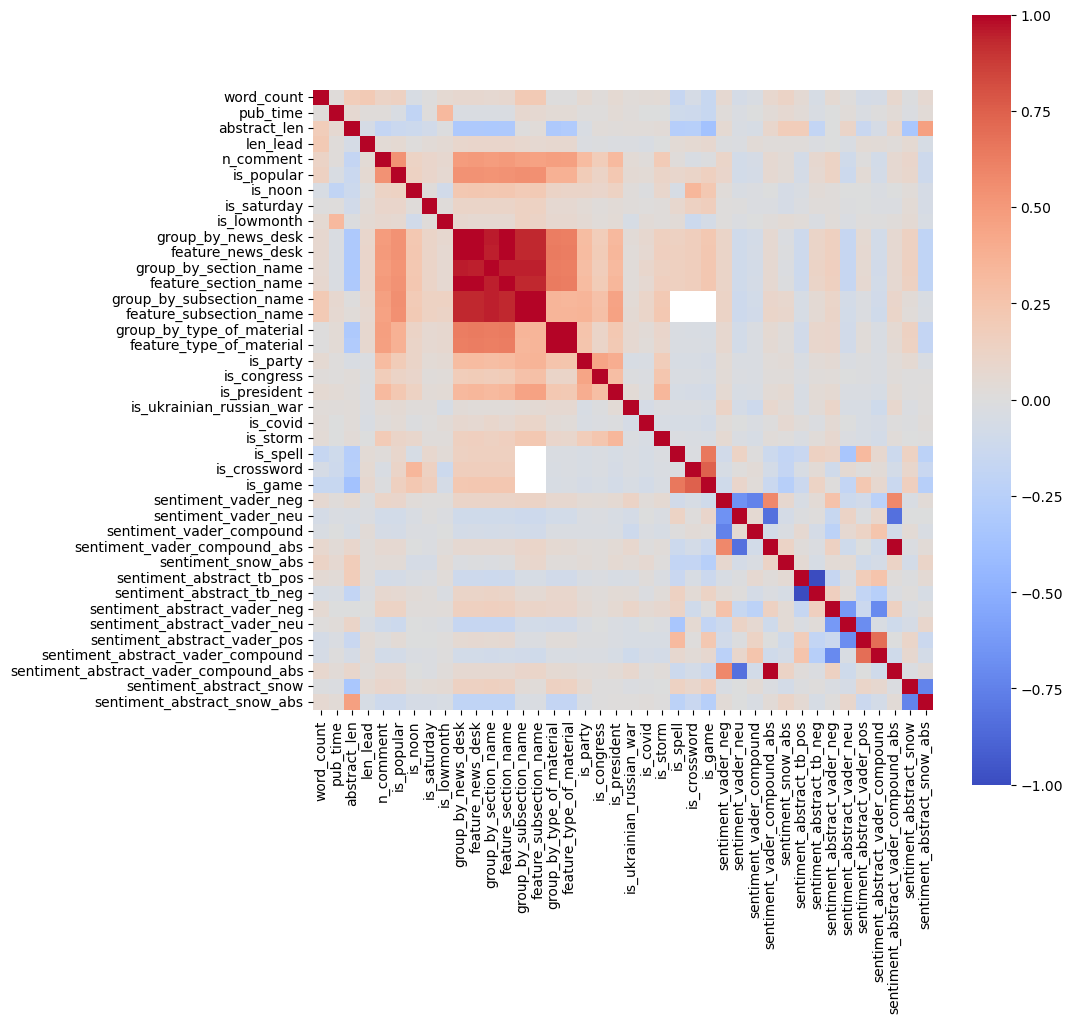

In [37]:
plt.figure(figsize=(10,10))
sns.heatmap(train.corr(), cmap='coolwarm', annot=False, square=True, fmt='.2f', cbar=True)

<AxesSubplot:>

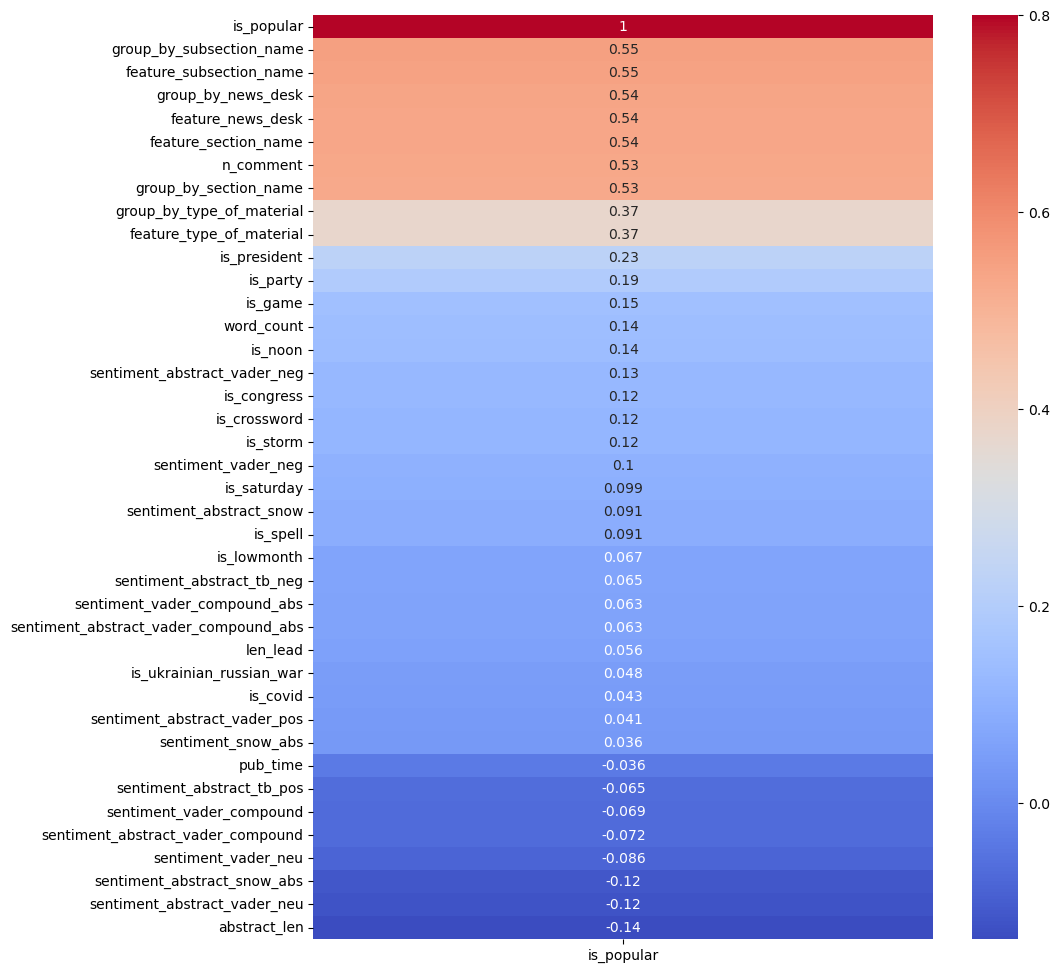

In [38]:
plt.figure(figsize=(10,12))
sns.heatmap(train.corr()[['is_popular']].sort_values(ascending=False, by='is_popular'), 
            cmap='coolwarm', annot=True, vmax=0.8)

# Check the features

In [39]:
train.to_pickle(f'./nytimes-dataset/{feat_data}.pkl')
feat = pd.read_pickle(f'./nytimes-dataset/{feat_data}.pkl')
feat

,word_count,pub_time,abstract_len,len_lead,n_comment,is_popular,is_noon,is_saturday,is_lowmonth,group_by_news_desk,...,sentiment_snow_abs,sentiment_abstract_tb_pos,sentiment_abstract_tb_neg,sentiment_abstract_vader_neg,sentiment_abstract_vader_neu,sentiment_abstract_vader_pos,sentiment_abstract_vader_compound,sentiment_abstract_vader_compound_abs,sentiment_abstract_snow,sentiment_abstract_snow_abs
0,882,0,8,54,854,1,1,0,1,0.957773,...,0.767729,0,1,0.000,0.680,0.320,0.5106,0.2960,0.421875,0.156251
12545,1027,9,12,52,339,1,0,0,1,0.957773,...,0.653023,1,0,0.000,0.866,0.134,0.1779,0.4215,0.615016,0.230032
8246,2358,9,14,55,602,1,0,0,1,0.957773,...,0.727890,0,1,0.000,1.000,0.000,0.0000,0.0000,0.267326,0.465347
17271,2213,15,15,66,123,1,0,0,1,0.957773,...,0.351888,1,0,0.199,0.801,0.000,-0.5390,0.5994,0.177501,0.644997
12529,1530,10,24,75,689,1,0,0,1,0.957773,...,0.770652,1,0,0.296,0.704,0.000,-0.7906,0.2960,0.078399,0.843202
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
882,1087,10,26,12,7,0,0,0,1,0.379630,...,0.256697,0,1,0.000,0.914,0.086,0.3291,0.0000,0.020590,0.958821
17583,562,15,128,128,3,0,0,0,1,0.286859,...,0.434530,1,0,0.043,0.789,0.168,0.9531,0.0000,0.000016,0.999968
2754,443,9,12,72,5,0,0,0,1,0.135531,...,0.397023,0,1,0.000,1.000,0.000,0.0000,0.0000,0.189069,0.621863
18481,745,15,23,10,2,0,0,0,1,0.286859,...,0.156251,0,1,0.000,1.000,0.000,0.0000,0.0000,0.039727,0.920546


Index([ 'print_section', 'print_page', 'pub_year',
       'abstract','abstract_dup', 'headline', 
       'headline_dup', 'headline_kicker', 'len_lead', 
       'is_popular'],
      dtype='object')